# Environment Setup

In [145]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import csv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Loading the Data

In [146]:
# where to retrieve the data from
theme_dict = {
    "AI": {
        "prices": "AIQ",
        "sentiment": "Data Science/ML/AI"
    },
    "Cybersecurity": {
        "prices": "CIBR",
        "sentiment": "Cyber Security"
    },
    "Social Media": {
        "prices": "SOCL",
        "sentiment": "Social Media"
    },
    "EV": {
        "prices": "ECAR.L",
        "sentiment": "Electric Vehicles"
    },
    "Transistors": {
        "prices": "SOXX",
        "sentiment": "Transistors"
    },
    "Cloud Computing": {
        "prices": "CLOU",
        "sentiment": "Cloud Computing"
    },
    "Streaming": {
        "prices": "BNGE",
        "sentiment": "Streaming"
    },
    "VR": {
        "prices": "VR",
        "sentiment": "AR/VR"
    },
    "TNX": {
        "prices": "TNX",
        "sentiment": None
    },
    "Market": {
        "prices": "GSPC",
        "sentiment": None
    }
}

# directory for prices data
prices_dir = "GetStockData"

# sentiment data
sentiment_file_path = "Theme_Sentiment_Results.csv"

In [147]:
pd.read_csv(sentiment_file_path)["theme"].unique()

array(['Social Media', 'Smartphone', 'Streaming', 'Smartwatch',
       'Transistors', 'Electric Vehicles', 'AR/VR', 'Cyber Security',
       'Data Science/ML/AI', 'Cloud Computing'], dtype=object)

In [148]:
def get_prices_data(theme):
  file_path = "{}/{}.csv".format(prices_dir, theme_dict[theme]["prices"])
  df = pd.read_csv(file_path)
  columns = df.columns
  df.rename(columns={col: col.lower() for col in columns}, inplace=True)
  df["date"] = pd.to_datetime(df["date"])
  df.sort_values(by="date", inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

def get_sentiment_data(theme):
  df = pd.read_csv(sentiment_file_path)
  columns = df.columns
  df.rename(columns={col: col.lower() for col in columns}, inplace=True)
  df = df[df["theme"] == theme_dict[theme]["sentiment"]]
  df1 = df.groupby("date")[["sentiment_score", "confidence"]].mean().reset_index()
  df2 = df.groupby("date")["theme"].count().reset_index()
  df2.rename(columns={"theme": "theme_freq"}, inplace=True)

  df["positive"] = np.where(df["sentiment_result"] == "positive", 1, 0)
  df["negative"] = np.where(df["sentiment_result"] == "negative", 1, 0)
  df3 = df.groupby("date")[["positive", "negative"]].sum().reset_index()
  df3["positive_frac"] = df3["positive"] / (df3["negative"] + df3["positive"])

  df = pd.merge(df1, df2, on="date").merge(df3, on="date")
  df["date"] = pd.to_datetime(df["date"])
  df.sort_values(by="date", inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

In [149]:
df = get_prices_data("Cybersecurity")
df.head()
df.shape
df["date"].min()
df["date"].max()

df = get_sentiment_data("Cybersecurity")
df.head()
df.shape
df["date"].min()
df["date"].max()

Timestamp('2024-10-27 00:00:00')

# 1-Day Regressions

## Predict Opening Price Tomorrow

In [150]:
def get_regression_data(price_data, sentiment_data):
  price_data["open_tomorrow"] = price_data["open"].shift(-1)
  price_data.dropna(inplace=True)
  price_data.reset_index(drop=True, inplace=True)
  df = pd.merge(
      price_data, sentiment_data, on="date",
      how="left"
  )
  df = df.sort_values(by="date")
  df = df.dropna()
  df.reset_index(drop=True, inplace=True)
  return df

In [151]:
themewise_data = {}
for theme in theme_dict.keys():
  price_data = get_prices_data(theme)
  sentiment_data = get_sentiment_data(theme)
  themewise_data[theme] = get_regression_data(price_data, sentiment_data)

themewise_data["Combined"] = pd.concat(themewise_data.values())

In [152]:
# partition by date
def partition_data(df, split_ratio=0.2):
  df = df.sort_values(by="date")

  train_df, test_df = df.iloc[:int(len(df)*(1-split_ratio))], df.iloc[int(len(df)*(1-split_ratio)):]
  return train_df, test_df

def run_regression_without_articles(df):
  features = ["open", "high", "low", "close", "volume"]
  target = "open_tomorrow"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Lasso(alpha=0.1))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression_with_articles(df):
  features = ["open", "high", "low", "close", "volume", "sentiment_score", "confidence", "theme_freq"]
  target = "open_tomorrow"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Lasso(alpha=0.1))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression(theme, df):
  print("----- {} -----".format(theme))
  print("Without Articles")
  run_regression_without_articles(df)
  print("With Articles")
  run_regression_with_articles(df)

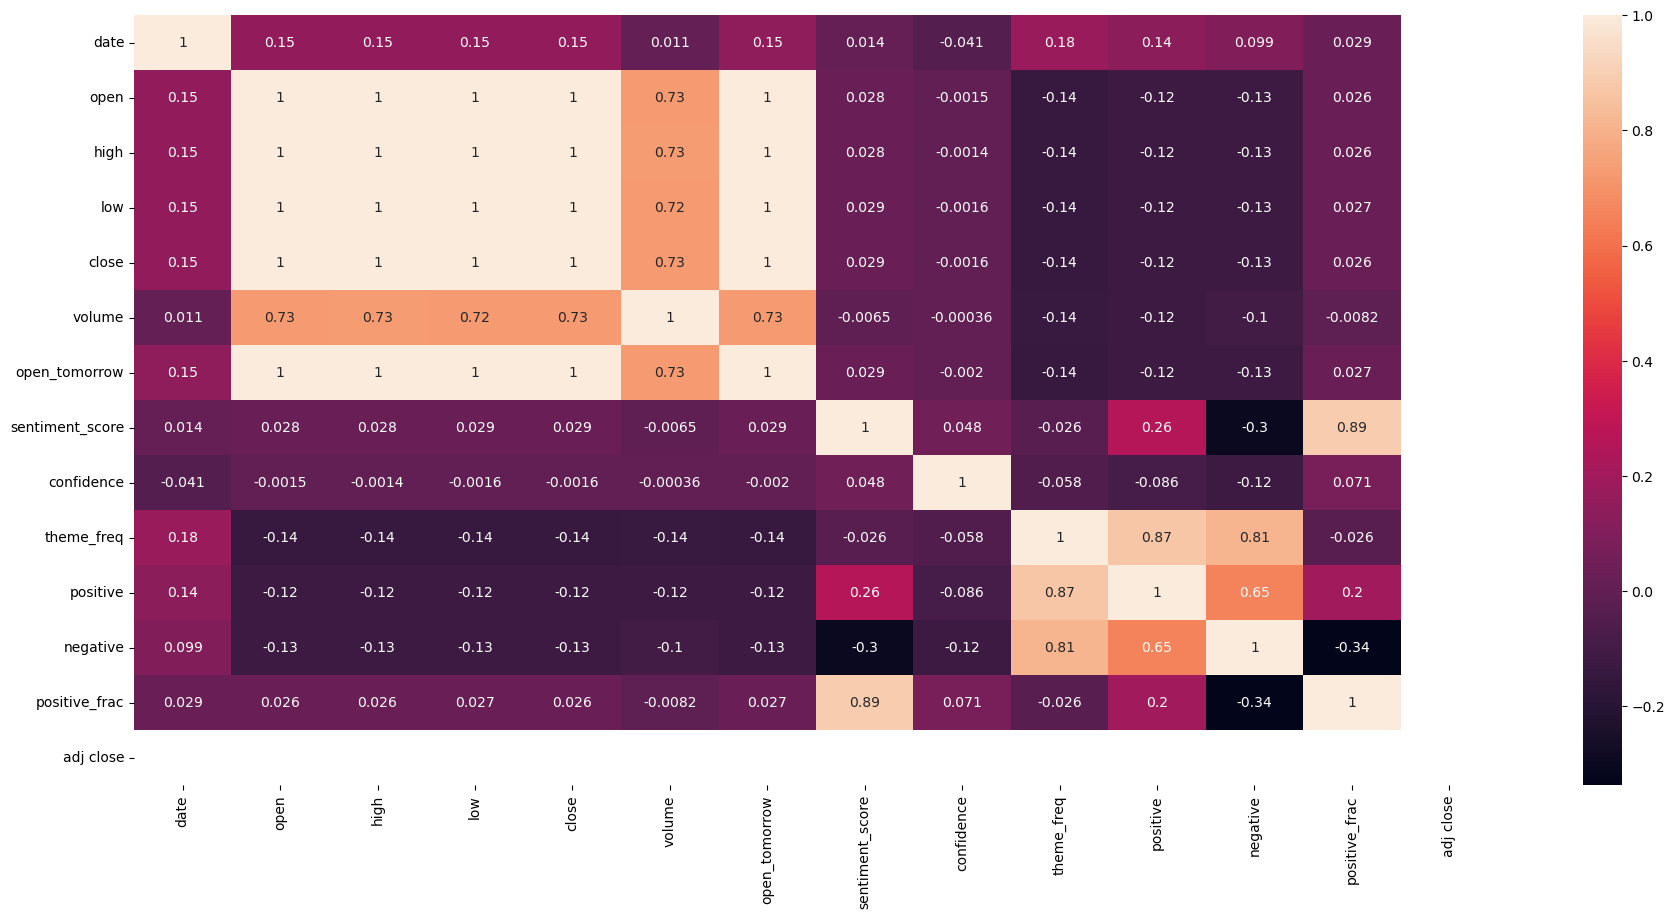

In [153]:
plt.figure(figsize=(22, 10)) 

df = themewise_data["Combined"]
sns.heatmap(df.corr(), annot=True)

plt.show()

In [154]:
for theme in themewise_data.keys():
  if theme == "TNX" or theme == "Market":
    continue
  df = themewise_data[theme]
  run_regression(theme, df)

----- AI -----
Without Articles
In-sample MSE: 0.06371076629473804
Out-of-sample MSE: 0.10059349726779242
In-sample R2: 0.9977192974972585
Out-of-sample R2: 0.9908047023983323
With Articles
In-sample MSE: 0.06371076629473804
Out-of-sample MSE: 0.10059349726779242
In-sample R2: 0.9977192974972585
Out-of-sample R2: 0.9908047023983323
----- Cybersecurity -----
Without Articles
In-sample MSE: 0.13635553285234833
Out-of-sample MSE: 0.2219946152314182
In-sample R2: 0.9986412698784245
Out-of-sample R2: 0.9944672809635647
With Articles
In-sample MSE: 0.13635553285234833
Out-of-sample MSE: 0.2219946152314182
In-sample R2: 0.9986412698784245
Out-of-sample R2: 0.9944672809635647
----- Social Media -----
Without Articles
In-sample MSE: 0.27611643117753504
Out-of-sample MSE: 0.2116485683393315
In-sample R2: 0.9983186727798427
Out-of-sample R2: 0.9656110559709311
With Articles
In-sample MSE: 0.27611643117753504
Out-of-sample MSE: 0.2116485683393315
In-sample R2: 0.9983186727798427
Out-of-sample R2: 

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.299e-01, tolerance: 4.581e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.299e-01, tolerance: 4.581e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

In-sample MSE: 0.6918675782175794
Out-of-sample MSE: 1.95261406014087
In-sample R2: 0.999434845615744
Out-of-sample R2: 0.999549459238661


## Predict 1 Day Return

Defined as Closing Tmrw / Closing Today - 1

In [155]:
def get_regression_data(price_data, sentiment_data):
  price_data["return"] = price_data["close"].shift(-1) / price_data["close"] - 1
  price_data["return_lag1"] = price_data["close"] / price_data["close"].shift(1) - 1
  price_data["return_lag1"] = price_data["close"] / price_data["close"].shift(1) - 1
  price_data["rolling_vol_30"] = price_data["return"].rolling(window=30).std()
  price_data.dropna(inplace=True)
  price_data.reset_index(drop=True, inplace=True)
  df = pd.merge(
      price_data, sentiment_data, on="date",
      how="left"
  )
  df = df.sort_values(by="date")
  df = df.dropna()
  df.reset_index(drop=True, inplace=True)
  return df

In [156]:
themewise_data = {}
for theme in theme_dict.keys():
  if theme == "TNX" or theme == "Market":
    continue
  price_data = get_prices_data(theme)
  sentiment_data = get_sentiment_data(theme)

  themewise_data[theme] = get_regression_data(price_data, sentiment_data)

themewise_data["Combined"] = pd.concat(themewise_data.values())

In [157]:
# partition by date
def partition_data(df, split_ratio=0.2):
  df = df.sort_values(by="date")

  train_df, test_df = df.iloc[:int(len(df)*(1-split_ratio))], df.iloc[int(len(df)*(1-split_ratio)):]
  return train_df, test_df

def run_regression_without_articles(df):
  # features = ["open", "high", "low", "close", "volume", "return_yesterday"]
  features = ["return_lag1"]
  target = "rolling_vol_30"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Lasso(alpha=0.00001))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression_with_articles(df):
  # features = ["open", "high", "low", "close", "volume", "sentiment_score", "confidence", "theme_freq", "return_yesterday"]
  sentiment_factors = ["theme_freq", "confidence", "positive", "negative", "positive_frac", "sentiment_score"]
  features = ["return_lag1"] + sentiment_factors
  target = "rolling_vol_30"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Lasso(alpha=0.00001))
  ])
  model.fit(X_train, y_train)
  lasso_model = model.named_steps['regressor']
  print("Lasso Coefficients:", lasso_model.coef_)
  print("Lasso Intercept:", lasso_model.intercept_)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression(theme, df):
  print("----- {} -----".format(theme))
  print("Without Articles")
  run_regression_without_articles(df)
  print("With Articles")
  run_regression_with_articles(df)

In [158]:
for theme in themewise_data.keys():
  if theme == "TNX" or theme == "Market":
    continue
  df = themewise_data[theme]
  run_regression(theme, df)

----- AI -----
Without Articles
In-sample MSE: 2.6879581610167492e-05
Out-of-sample MSE: 1.1399088179586832e-05
In-sample R2: 0.0017060229017421547
Out-of-sample R2: -6.021454764905783
With Articles
Lasso Coefficients: [-8.67659991e-05  1.33905000e-03 -5.86123987e-04 -1.16175275e-03
  5.80247715e-04  6.14592557e-04 -2.28312055e-04]
Lasso Intercept: 0.014968011497124982
In-sample MSE: 2.4706954045297126e-05
Out-of-sample MSE: 1.4285835973487635e-05
In-sample R2: 0.08239630461607228
Out-of-sample R2: -7.799594273367829
----- Cybersecurity -----
Without Articles
In-sample MSE: 5.164719321881178e-05
Out-of-sample MSE: 1.6172752935323986e-05
In-sample R2: 0.0004627830736905203
Out-of-sample R2: -4.0543243282248005
With Articles
Lasso Coefficients: [ 7.72186667e-05  4.42060650e-03 -8.42016250e-05 -1.59438911e-03
  4.80536989e-04 -1.32731417e-05 -3.07229412e-04]
Lasso Intercept: 0.015230977927145482
In-sample MSE: 3.8722903543612345e-05
Out-of-sample MSE: 1.1350861458881244e-05
In-sample R2: 

<Axes: >

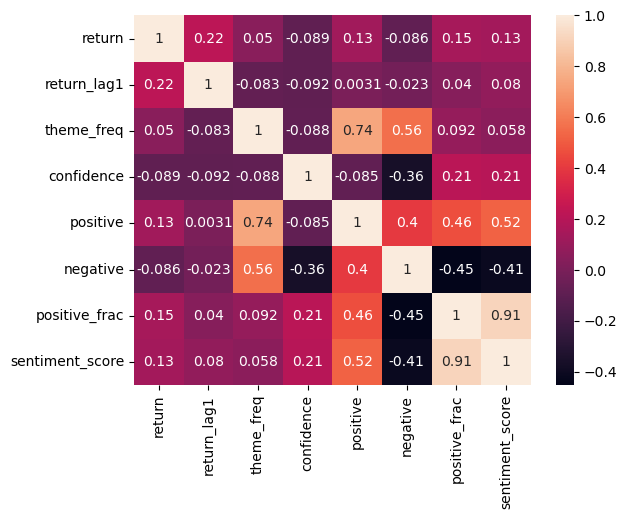

In [159]:
# plot correlation matrix for columns
sentiment_factors = ["theme_freq", "confidence", "positive", "negative", "positive_frac", "sentiment_score"]
cols = ["return", "return_lag1"] + sentiment_factors
df = themewise_data["VR"]
sns.heatmap(df[cols].corr(), annot=True)

# Predicting Next Day Volume

In [160]:
def get_regression_data(price_data, sentiment_data):
  price_data["volume_tomorrow"] = price_data["volume"].shift(-1)
  price_data["volume_change"] = price_data["volume_tomorrow"] / price_data["volume"] - 1
  price_data["volume_change_lag1"] = price_data["volume_change"].shift(1)
  df = pd.merge(
      price_data, sentiment_data, on="date",
      how="left"
  )
  df = df.sort_values(by="date")
  df = df.dropna()
  df.reset_index(drop=True, inplace=True)
  return df

In [161]:
themewise_data = {}
for theme in theme_dict.keys():
  if theme == "TNX" or theme == "Market":
    continue
  price_data = get_prices_data(theme)
  sentiment_data = get_sentiment_data(theme)
  themewise_data[theme] = get_regression_data(price_data, sentiment_data)

themewise_data["Combined"] = pd.concat(themewise_data.values())

<Axes: >

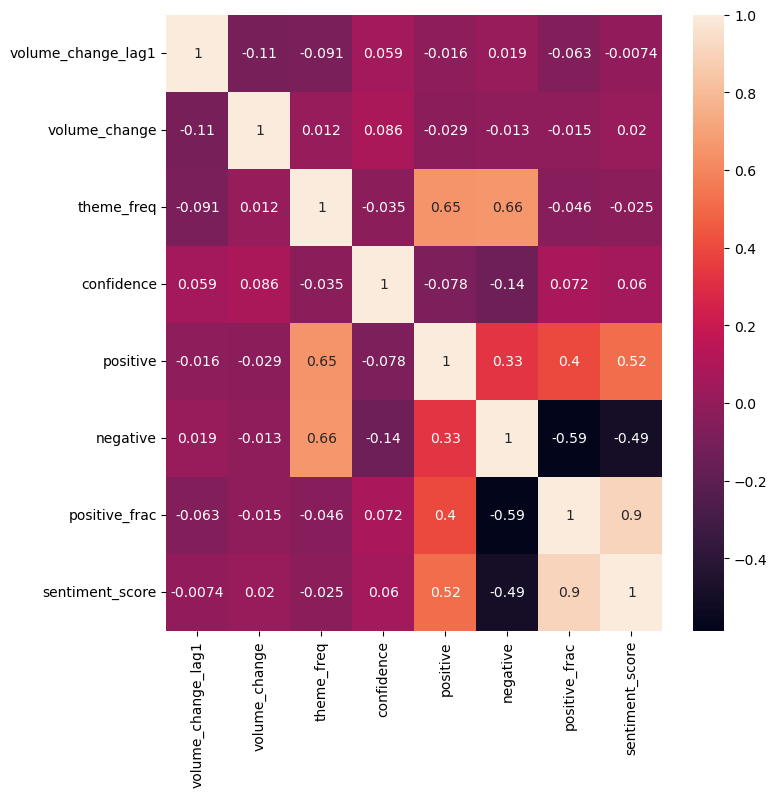

In [162]:
# plot correlation matrix for columns
df = themewise_data["AI"]
cols = ["volume_change_lag1", "volume_change"] + sentiment_factors
plt.figure(figsize=(8, 8))
sns.heatmap(df[cols].corr(), annot=True)

In [163]:
# partition by date
def partition_data(df, split_ratio=0.2):
  df = df.sort_values(by="date")

  train_df, test_df = df.iloc[:int(len(df)*(1-split_ratio))], df.iloc[int(len(df)*(1-split_ratio)):]
  return train_df, test_df

def run_regression_without_articles(df):
  features = ["volume"]
  target = "volume_tomorrow"

  train_df, test_df = partition_data(df)

  mean_volume = train_df[target].mean()
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]
  y_train, y_test = y_train / mean_volume, y_test / mean_volume

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=0.01))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression_with_articles(df):
  features = ["volume", "confidence", "sentiment_score", "theme_freq"]
  target = "volume_tomorrow"

  train_df, test_df = partition_data(df)
  mean_volume = train_df[target].mean()

  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]
  y_train, y_test = y_train / y_train.mean(), y_test / y_train.mean()

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=0.01))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression(theme, df):
  print("----- {} -----".format(theme))
  print("Without Articles")
  run_regression_without_articles(df)
  print("With Articles")
  run_regression_with_articles(df)

In [164]:
for theme in themewise_data.keys():
  if theme == "TNX" or theme == "Market":
    continue
  df = themewise_data[theme]
  run_regression(theme, df)

----- AI -----
Without Articles
In-sample MSE: 1.989766957770814
Out-of-sample MSE: 16.655986140024616
In-sample R2: 0.48583412820376937
Out-of-sample R2: 0.09062860849882826
With Articles
In-sample MSE: 1.8990762614496974
Out-of-sample MSE: 17.629904383854928
In-sample R2: 0.5092690640165516
Out-of-sample R2: 0.03745533006579027
----- Cybersecurity -----
Without Articles
In-sample MSE: 0.3964101593662622
Out-of-sample MSE: 0.39007036059085903
In-sample R2: 0.49417939029781444
Out-of-sample R2: -0.2545605824507773
With Articles
In-sample MSE: 0.3953595467867519
Out-of-sample MSE: 0.38944357449001105
In-sample R2: 0.49551997525249436
Out-of-sample R2: -0.25254468681963815
----- Social Media -----
Without Articles
In-sample MSE: 1.2221125248957387
Out-of-sample MSE: 0.45297408613264406
In-sample R2: 0.10862215696783639
Out-of-sample R2: -0.8965437721798324
With Articles
In-sample MSE: 1.2194772651529018
Out-of-sample MSE: 0.4563223862682403
In-sample R2: 0.11054424850813849
Out-of-sample

## Returns using Market Rate and Risk-free Rate

In [165]:
def get_regression_data(price_data, sentiment_data):
  price_data["return"] = price_data["close"].shift(-1) / price_data["close"] - 1
  price_data["return_lag1"] = price_data["close"] / price_data["close"].shift(1) - 1

  market_data = get_prices_data("Market")
  market_data["mkt_return"] = market_data["close"] / market_data["close"].shift(1) - 1

  risk_free_data = get_prices_data("TNX")
  risk_free_data["risk_free"] = risk_free_data["close"].shift(-1) / risk_free_data["close"] - 1
  risk_free_data["risk_free_lag1"] = risk_free_data["close"] / risk_free_data["close"].shift(1) - 1

  price_data = pd.merge(
      price_data, market_data[["date", "mkt_return"]],
      on="date", how="left"
  )
  price_data = pd.merge(
      price_data, risk_free_data[["date", "risk_free", "risk_free_lag1"]],
      on="date", how="left"
  )

  price_data["excess_return"] = price_data["return"] - price_data["risk_free"]
  price_data["excess_return_lag1"] = price_data["return_lag1"] - price_data["risk_free_lag1"]
  price_data["excess_mkt"] = price_data["mkt_return"] - price_data["risk_free_lag1"]

  price_data.dropna(inplace=True)
  price_data.reset_index(drop=True, inplace=True)
  df = pd.merge(
      price_data, sentiment_data, on="date",
      how="left"
  )
  df = df.sort_values(by="date")
  df = df.dropna()
  df.reset_index(drop=True, inplace=True)
  return df

In [166]:
themewise_data = {}
for theme in theme_dict.keys():
  price_data = get_prices_data(theme)
  sentiment_data = get_sentiment_data(theme)
  themewise_data[theme] = get_regression_data(price_data, sentiment_data)

themewise_data["Combined"] = pd.concat(themewise_data.values())

In [167]:
# partition by date
def partition_data(df, split_ratio=0.2):
  df = df.sort_values(by="date")

  train_df, test_df = df.iloc[:int(len(df)*(1-split_ratio))], df.iloc[int(len(df)*(1-split_ratio)):]
  return train_df, test_df

def run_regression_without_articles(df):
  # features = ["open", "high", "low", "close", "volume", "return_yesterday"]
  features = ["return_lag1"]
  target = "return"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=2.0))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression_with_articles(df):
  # features = ["open", "high", "low", "close", "volume", "sentiment_score", "confidence", "theme_freq", "return_yesterday"]
  sentiment_factors = ["theme_freq", "confidence", "positive", "negative", "positive_frac", "sentiment_score"]
  features = ["return_lag1"] + sentiment_factors
  target = "return"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=2.0))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression(theme, df):
  print("----- {} -----".format(theme))
  print("Without Articles")
  run_regression_without_articles(df)
  print("With Articles")
  run_regression_with_articles(df)

<Axes: >

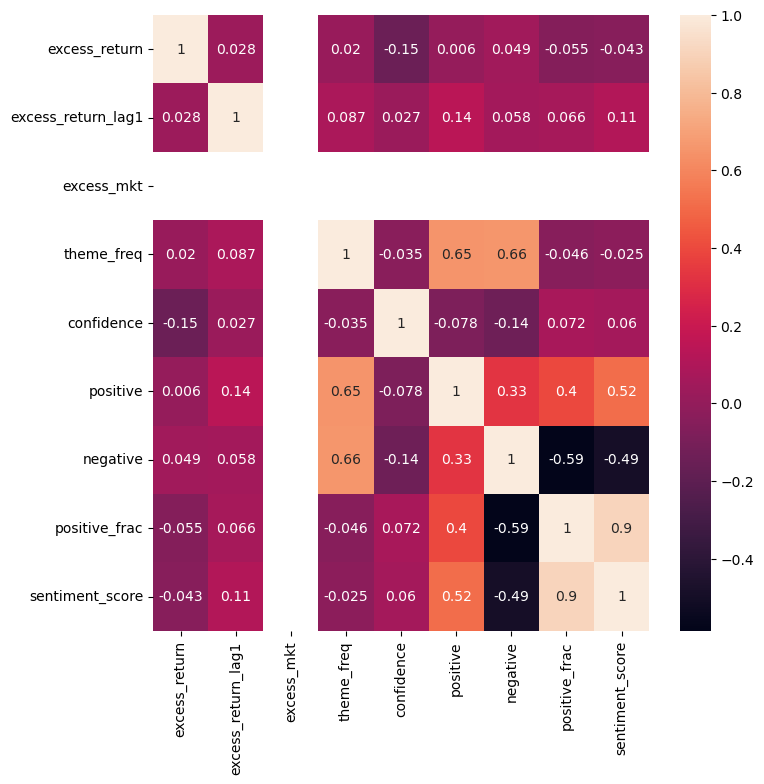

In [168]:
# plot correlation matrix for columns
sentiment_factors = ["theme_freq", "confidence", "positive", "negative", "positive_frac", "sentiment_score"]
df = themewise_data["AI"]
cols = ["excess_return", "excess_return_lag1", "excess_mkt"] + sentiment_factors
plt.figure(figsize=(8, 8))
sns.heatmap(df[cols].corr(), annot=True)

In [169]:
# partition by date
def partition_data(df, split_ratio=0.2):
  df = df.sort_values(by="date")

  train_df, test_df = df.iloc[:int(len(df)*(1-split_ratio))], df.iloc[int(len(df)*(1-split_ratio)):]
  return train_df, test_df

def run_regression_without_articles(df):
  # features = ["open", "high", "low", "close", "volume", "return_yesterday"]
  features = ["excess_return_lag1", "excess_mkt"]
  target = "excess_return"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=0.1))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression_with_articles(df):
  # features = ["open", "high", "low", "close", "volume", "sentiment_score", "confidence", "theme_freq", "return_yesterday"]
  sentiment_factors = ["theme_freq", "confidence", "positive", "negative", "positive_frac", "sentiment_score"]
  features = ["excess_return_lag1", "excess_mkt"] + sentiment_factors
  target = "excess_return"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=0.1))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression(theme, df):
  print("----- {} -----".format(theme))
  print("Without Articles")
  run_regression_without_articles(df)
  print("With Articles")
  run_regression_with_articles(df)

In [170]:
for theme in themewise_data.keys():
  if theme == "TNX" or theme == "Market":
    continue
  df = themewise_data[theme]
  run_regression(theme, df)

----- AI -----
Without Articles
In-sample MSE: 0.0007886012615924085
Out-of-sample MSE: 0.0004604889218976251
In-sample R2: 0.001566918318570587
Out-of-sample R2: -0.06281611520932562
With Articles
In-sample MSE: 0.0007675325259394018
Out-of-sample MSE: 0.00046691300252565585
In-sample R2: 0.02824164443134125
Out-of-sample R2: -0.07764300048756256
----- Cybersecurity -----
Without Articles
In-sample MSE: 0.0019322823025584622
Out-of-sample MSE: 0.0003927936173992793
In-sample R2: 0.0069196329738053786
Out-of-sample R2: -0.00899751135896354
With Articles
In-sample MSE: 0.001909256231463767
Out-of-sample MSE: 0.00040156035097343323
In-sample R2: 0.018753690090415276
Out-of-sample R2: -0.0315172570148019
----- Social Media -----
Without Articles
In-sample MSE: 0.0012288910959849092
Out-of-sample MSE: 0.0005126511646947067
In-sample R2: 0.0002761066723998562
Out-of-sample R2: -0.0007561628194885373
With Articles
In-sample MSE: 0.0012071507874807077
Out-of-sample MSE: 0.000520989720144712
I

## No Prediction: Just augmenting CAPM for explaining returns

In [171]:
# partition by date
def partition_data(df, split_ratio=0.2):
  df = df.sort_values(by="date")

  train_df, test_df = df.iloc[:int(len(df)*(1-split_ratio))], df.iloc[int(len(df)*(1-split_ratio)):]
  return train_df, test_df

def run_regression_without_articles(df):
  # features = ["open", "high", "low", "close", "volume", "return_yesterday"]
  features = ["excess_mkt"]
  target = "excess_return_lag1"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=0.1))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression_with_articles(df):
  # features = ["open", "high", "low", "close", "volume", "sentiment_score", "confidence", "theme_freq", "return_yesterday"]
  # sentiment_factors = ["theme_freq", "confidence", "positive", "negative", "positive_frac", "sentiment_score"]
  sentiment_factors = ["positive", "sentiment_score"]
  features = ["excess_mkt"] + sentiment_factors
  target = "excess_return_lag1"

  train_df, test_df = partition_data(df)
  X_train, y_train = train_df[features], train_df[target]
  X_test, y_test = test_df[features], test_df[target]

  model = Pipeline([
      ("scaler", StandardScaler()),
      ("regressor", Ridge(alpha=0.1))
  ])
  model.fit(X_train, y_train)

  print("In-sample MSE: {}".format(mean_squared_error(y_train, model.predict(X_train))))
  print("Out-of-sample MSE: {}".format(mean_squared_error(y_test, model.predict(X_test))))

  print("In-sample R2: {}".format(r2_score(y_train, model.predict(X_train))))
  print("Out-of-sample R2: {}".format(r2_score(y_test, model.predict(X_test))))

def run_regression(theme, df):
  print("----- {} -----".format(theme))
  print("Without Articles")
  run_regression_without_articles(df)
  print("With Articles")
  run_regression_with_articles(df)

In [172]:
for theme in themewise_data.keys():
  if theme == "TNX" or theme == "Market":
    continue
  df = themewise_data[theme]
  run_regression(theme, df)

----- AI -----
Without Articles
In-sample MSE: 0.0010131074937536665
Out-of-sample MSE: 0.0006648285199470369
In-sample R2: 0.0
Out-of-sample R2: -0.049184698877071664
With Articles
In-sample MSE: 0.000997517340428003
Out-of-sample MSE: 0.0006273484110424459
In-sample R2: 0.015388449322292996
Out-of-sample R2: 0.009963721497667777
----- Cybersecurity -----
Without Articles
In-sample MSE: 0.001961561504514963
Out-of-sample MSE: 0.00040871385247957353
In-sample R2: 0.0
Out-of-sample R2: -0.0032948221890216622
With Articles
In-sample MSE: 0.0019540975388838283
Out-of-sample MSE: 0.00041900483189201816
In-sample R2: 0.003805114249007535
Out-of-sample R2: -0.02855671702601037
----- Social Media -----
Without Articles
In-sample MSE: 0.0010478242212310813
Out-of-sample MSE: 0.0005365646244372381
In-sample R2: 0.0
Out-of-sample R2: -4.2366963831197424e-05
With Articles
In-sample MSE: 0.00103940846295093
Out-of-sample MSE: 0.0005571130107167833
In-sample R2: 0.008031650833823623
Out-of-sample R